IE552 Neural Differential Equation Paper presentation Code

20245537 JaeHyeon, An

Paper: Stable Neural Stochastic Differential Equations in Analyzing Irregular Time Series Data (ICLR 2024)


This code is about simple OU process with 4 methods,

Neural SDE, Neural LSDE, Neural LNSDE and Neural GSDE.

You can compare each training losses at below and this is essentially doing same with the Figure.2 in the paper.

In [ ]:
!pip install torchcde
!pip install torchsde
!pip install tqdm

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchcde
import torchsde
from torch.utils.data import Dataset, DataLoader

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
def ou_process(T, N, theta, mu, sigma, X0):
    """
    Simulate the Ornstein-Uhlenbeck process.

    Parameters:
    T (float): Total time.
    N (int): Number of time steps.
    theta (float): Rate of mean reversion.
    mu (float): Long-term mean.
    sigma (float): Volatility.
    X0 (float): Initial value.

    Returns:
    np.ndarray: Simulated values of the OU process.
    """
    dt = T / N
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0

    for i in range(1, N):
        dW = np.random.normal(0, np.sqrt(dt))
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW

    return t, X

def generate_data(num_samples, T, N, theta, mu, sigma, X0):
    data_list = []
    for _ in range(num_samples):
        t, X = ou_process(T, N, theta, mu, sigma, X0)
        data_list.append([t, X])

    total_data = torch.Tensor(np.array(data_list))  # [Batch size, Dimension, Length]
    total_data = total_data.permute(0, 2, 1)  # [Batch size, Length, Dimension]

    max_len = total_data.shape[1]
    times = torch.linspace(0, 1, max_len)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(total_data, times)

    return total_data, coeffs, times

class OU_Dataset(Dataset):
    def __init__(self, data, coeffs):
        self.data = data
        self.coeffs = coeffs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            self.data[idx, ...],
            self.coeffs[idx, ...],
        )

def split_data(data, coeffs, train_ratio=0.8):
    total_size = len(data)
    train_size = int(total_size * train_ratio)

    train_idx = np.random.choice(range(total_size), train_size, replace=False)
    test_idx = np.array([i for i in range(total_size) if i not in train_idx])

    train_data = data[train_idx, ...]
    test_data = data[test_idx, ...]
    train_coeffs = coeffs[train_idx, ...]
    test_coeffs = coeffs[test_idx, ...]

    return train_data, train_coeffs, test_data, test_coeffs

def create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, batch_size=16):
    train_dataset = OU_Dataset(train_data, train_coeffs)
    test_dataset = OU_Dataset(test_data, test_coeffs)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Parameters
config = {
    'num_samples': 1000,
    'T': 10.0,
    'N': 20,
    'theta': 0.2,
    'mu': 0.0,
    'sigma': 0.1,
    'X0': 1.0,
    'train_ratio': 0.8,
    'batch_size': 16,
    'seed': 42,
}

# Ensure reproducibility
seed_everything(config['seed'])

# Generate data
total_data, coeffs, times = generate_data(config['num_samples'], config['T'], config['N'], config['theta'], config['mu'], config['sigma'], config['X0'])

# Split data
train_data, train_coeffs, test_data, test_coeffs = split_data(total_data, coeffs, config['train_ratio'])

# Create data loaders
train_loader, test_loader = create_data_loaders(train_data, train_coeffs, test_data, test_coeffs, config['batch_size'])


In [4]:
class LipSwish(nn.Module):
    def forward(self, x):
        return 0.909 * torch.nn.functional.silu(x)

class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_dim, num_layers, tanh=False, activation='lipswish'):
        super().__init__()

        if activation == 'lipswish':
            activation_fn = LipSwish()
        else:
            activation_fn = nn.ReLU()

        model = [nn.Linear(in_size, hidden_dim), activation_fn]
        for _ in range(num_layers - 1):
            model.append(nn.Linear(hidden_dim, hidden_dim))
            model.append(activation_fn)
        model.append(nn.Linear(hidden_dim, out_size))
        if tanh:
            model.append(nn.Tanh())
        self._model = nn.Sequential(*model)

    def forward(self, x):
        return self._model(x)

In [5]:
class NeuralSDEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_hidden_dim, num_layers, activation='lipswish'):
        super(NeuralSDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal" # or "scalar"

        self.linear_in = nn.Linear(hidden_dim + 1, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)
        self.linear_out = nn.Linear(hidden_dim, hidden_dim)
        self.noise_in = nn.Linear(hidden_dim + 1, hidden_dim)
        self.g_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)

    def set_X(self, coeffs, times):
        self.coeffs = coeffs
        self.times = times
        self.X = torchcde.CubicSpline(self.coeffs, self.times)

    def f(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.linear_in(torch.cat((t, y), dim=-1))
        return self.f_net(yy)

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.noise_in(torch.cat((t, y), dim=-1))
        return self.g_net(yy)

class NeuralLSDEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_hidden_dim, num_layers, activation='lipswish'):
        super(NeuralLSDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal"

        self.linear_X = nn.Linear(input_dim, hidden_dim)
        self.emb = nn.Linear(hidden_dim*2, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)
        self.linear_out = nn.Linear(hidden_dim,hidden_dim)
        self.noise_in = nn.Linear(1, hidden_dim)
        self.g_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)

    def set_X(self, coeffs, times):
        self.coeffs = coeffs
        self.times = times
        self.X = torchcde.CubicSpline(self.coeffs, self.times)

    def f(self, t, y):
        Xt = self.X.evaluate(t)
        Xt = self.linear_X(Xt)

        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        z = self.emb(torch.cat([y,Xt], dim=-1))
        z = self.f_net(z)
        return self.linear_out(z)

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        tt = self.noise_in(t)
        return self.g_net(tt)

class NeuralLNSDEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_hidden_dim, num_layers, activation='lipswish'):
        super(NeuralLNSDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal"

        self.linear_in = nn.Linear(hidden_dim + 1, hidden_dim)
        self.linear_X = nn.Linear(input_dim, hidden_dim)
        self.emb = nn.Linear(hidden_dim*2, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)
        self.linear_out = nn.Linear(hidden_dim, hidden_dim)
        self.noise_in = nn.Linear(1, hidden_dim)
        self.g_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)

    def set_X(self, coeffs, times):
        self.coeffs = coeffs
        self.times = times
        self.X = torchcde.CubicSpline(self.coeffs, self.times)

    def f(self, t, y):
        Xt = self.X.evaluate(t)
        Xt = self.linear_X(Xt)

        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.linear_in(torch.cat((t, y), dim=-1))
        z = self.emb(torch.cat([yy,Xt], dim=-1))
        z = self.f_net(z)
        return self.linear_out(z)

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        tt = self.noise_in(t)
        return self.g_net(tt)

class NeuralGSDEFunc(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_hidden_dim, num_layers, activation='lipswish'):
        super(NeuralGSDEFunc, self).__init__()
        self.sde_type = "ito"
        self.noise_type = "diagonal"

        self.linear_in = nn.Linear(hidden_dim + 1, hidden_dim)
        self.linear_X = nn.Linear(input_dim, hidden_dim)
        self.emb = nn.Linear(hidden_dim*2, hidden_dim)
        self.f_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)
        self.linear_out = nn.Linear(hidden_dim, hidden_dim)
        self.noise_in = nn.Linear(1, hidden_dim)
        self.g_net = MLP(hidden_dim, hidden_dim, hidden_hidden_dim, num_layers, activation=activation)

    def set_X(self, coeffs, times):
        self.coeffs = coeffs
        self.times = times
        self.X = torchcde.CubicSpline(self.coeffs, self.times)

    def f(self, t, y):
        Xt = self.X.evaluate(t)
        Xt = self.linear_X(Xt)

        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        yy = self.linear_in(torch.cat((t, y), dim=-1))
        z = self.emb(torch.cat([yy,Xt], dim=-1))
        z = self.f_net(z) * y
        return self.linear_out(z)

    def g(self, t, y):
        if t.dim() == 0:
            t = torch.full_like(y[:, 0], fill_value=t).unsqueeze(-1)
        tt = self.noise_in(t)
        return self.g_net(tt) * y

class NDE_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation='lipswish', vector_field=None):
        super(NDE_model, self).__init__()
        self.func = vector_field(input_dim, hidden_dim, hidden_dim, num_layers, activation=activation)
        self.initial = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)

    def forward(self, coeffs, times):
        self.func.set_X(coeffs, times)

        y0 = self.func.X.evaluate(times[0])
        y0 = self.initial(y0)

        z = torchsde.sdeint(sde=self.func,
                            y0=y0,
                            ts=times,
                            dt=0.05,
                            method='euler')
        z = z.permute(1,0,2)
        return self.decoder(z)

In [6]:
input_dim = 2
output_dim = 1
hidden_dim = 32
num_layers = 1

num_epochs = 100
lr = 1e-3

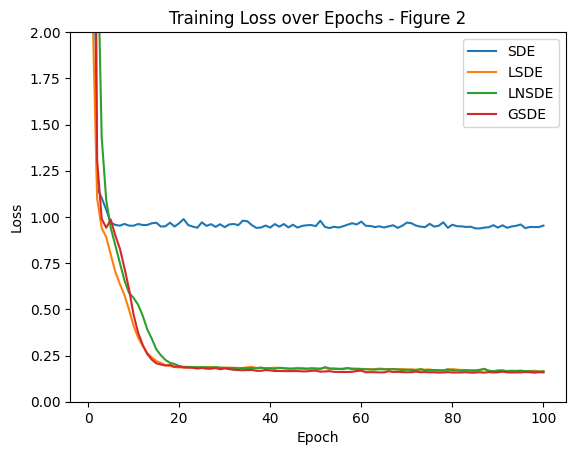

In [7]:
model_name = ['SDE', 'LSDE', 'LNSDE', 'GSDE']
lossSDE = []
lossLSDE = []
lossLNSDE = []
lossGSDE = []

func_name = {
    'SDE':NeuralSDEFunc,
    'LSDE':NeuralLSDEFunc,
    'LNSDE':NeuralLNSDEFunc,
    'GSDE':NeuralGSDEFunc
}

loss_list = {
    'SDE':lossSDE,
    'LSDE':lossLSDE,
    'LNSDE':lossLNSDE,
    'GSDE':lossGSDE,
}

for nnn in model_name:
  model = NDE_model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, vector_field=func_name[nnn]).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.MSELoss()

  for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0
    for batch in train_loader:
        coeffs = batch[1].to(device)
        times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

        optimizer.zero_grad()
        true = batch[0][:,:,1].to(device)
        pred = model(coeffs, times).squeeze(-1)
        loss = criterion(pred, true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_list[nnn].append(total_loss)
    if epoch % num_epochs == 0:
        avg_loss = total_loss / len(train_loader)

        model.eval()
        total_loss = 0
        all_preds = []
        all_trues = []
        with torch.no_grad():
            for batch in test_loader:
                coeffs = batch[1].to(device)
                times = torch.linspace(0, 1, batch[0].shape[1]).to(device)

                true = batch[0][:,:,1].to(device)
                pred = model(coeffs, times).squeeze(-1)
                loss = criterion(pred, true)
                total_loss += loss.item()

                all_preds.append(pred.cpu())
                all_trues.append(true.cpu())

        avg_loss = total_loss / len(test_loader)

        all_preds = torch.cat(all_preds, dim=0)
        all_trues = torch.cat(all_trues, dim=0)

plt.plot(range(1, num_epochs+1), lossSDE, label = 'SDE')
plt.plot(range(1, num_epochs+1), lossLSDE, label = 'LSDE')
plt.plot(range(1, num_epochs+1), lossLNSDE, label = 'LNSDE')
plt.plot(range(1, num_epochs+1), lossGSDE, label = 'GSDE')
plt.ylim(0,2)
plt.legend(loc='upper right')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs - Figure 2')
plt.show()